In [1]:
import yfinance as yf
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [24]:
################# input ticker ###############
ticker = "msft"
stock = yf.Ticker(ticker)

In [15]:
######################## financial report analysis ####################
unit = 'year'

if unit == 'quart':
    fin = stock.quarterly_financials
    bs = stock.quarterly_balance_sheet
elif unit == 'year':
    fin = stock.financials
    bs = stock.balance_sheet

if(fin.shape[0] == 0):
    print('Invalid Ticker')
else:
    ## Ratio of totoal liab and total asset
    lia_ast = bs.loc['Total Liab', :]/bs.loc['Total Assets', :]

    ## Ratio of current totoal liab and current total asset
    lia_ast_cur = bs.loc['Total Current Liabilities', :]/bs.loc['Total Current Assets', :]
    
    ## cash/liab
    cash_lia_cur = bs.loc['Cash', :]/bs.loc['Total Current Liabilities', :]
    cash_lia = bs.loc['Cash', :]/bs.loc['Total Liab', :]
    
    ## (cash+short_term_invest)/laib
    if 'Short Term Investments' in bs.index:
        cain_lia_cur = (bs.loc['Cash', :] + bs.loc['Short Term Investments',:])/bs.loc['Total Current Liabilities', :]
        cain_lia = (bs.loc['Cash', :] + bs.loc['Short Term Investments',:])/bs.loc['Total Liab', :]
    else:
        cain_lia_cur = cash_lia_cur
        cain_lia = cash_lia 
    
    dfasset = [lia_ast_cur, lia_ast, cash_lia_cur, cash_lia, cain_lia_cur, cain_lia]
    asset_smry = pd.DataFrame(dfasset).T
    asset_smry.columns = ['Cur_Liab/Asset', 'Tot_Liab/Asset', 'Cur_Cash/Liab', 'Tot_Cash/Liab', 'Cur_C_STI/Liab', 'Tot_C_STI/Liab']
    
    ## gross
    rev_total = fin.loc['Total Revenue', :]
    rev_cost = fin.loc['Cost Of Revenue', :]
    gross_pchg = [round((rev_total[i]-rev_total[i+1])/rev_total[i+1]*100, 2) for i in range(len(rev_total)-1)]+[0]
    gross_pchg = pd.DataFrame(gross_pchg)
    gross_pchg.index = rev_total.index
  
    ## gross marging
    gmargin = (rev_total-rev_cost)/rev_total
    gmargin_pchg = [round((gmargin[i]-gmargin[i+1])/gmargin[i+1]*100, 2) for i in range(len(gmargin)-1)]+[0]
    gmargin_pchg = pd.DataFrame(gmargin_pchg)
    gmargin_pchg.index = gmargin.index
    
    gross_smry = pd.concat([rev_total, gross_pchg, gmargin, gmargin_pchg], axis = 1)
    gross_smry.columns = ['Gross', 'Gross_PCHG(%)', 'Gross_Margin', 'GM_PCHG(%)']
    
    ## net income
    ninc = fin.loc['Net Income', :]
    ninc_pchg_prev = [round((ninc[i] - ninc[i+1])/ninc[i+1]*100, 2) for i in range(len(ninc)-1)]+[0]
    ninc_pchg_prev = pd.DataFrame(ninc_pchg_prev)
    ninc_pchg_prev.index = ninc.index
    
    ninc_pchg = [round((ninc[i] - ninc[-1])/ninc[-1]*100, 2) for i in range(len(ninc))]
    ninc_pchg = pd.DataFrame(ninc_pchg)
    ninc_pchg.index = ninc.index
    
    ninc_smry = pd.concat([ninc, ninc_pchg_prev, ninc_pchg], axis = 1)
    ninc_smry.columns = ['Net Income', 'Net Income PCHG Prev(%)', 'Net Income PCHG(%)']
    
    ## return on equity
    roes = [round(fin.loc['Net Income', :][i]/bs.loc['Total Stockholder Equity', :][i]*100, 2) for i in range(len(fin.loc['Net Income', :]))]
    roes = pd.DataFrame(roes)
    roes.index = fin.loc['Net Income', :].index
    roes.columns = ['Return on Equity(%)']
    
    ## PB ratio 
    pb_ratio = stock.info['marketCap']/bs.loc['Net Tangible Assets', :][0]
    
    ## summaries
    print(round(asset_smry, 3))
    print(gross_smry)
    print(ninc_smry)
    print(roes)
    print('PB Ratio: '+str(round(pb_ratio, 3)))

            Cur_Liab/Asset  Tot_Liab/Asset  Cur_Cash/Liab  Tot_Cash/Liab  \
                                                                           
2021-12-31           1.193           0.726          0.033          0.004   
2020-12-31           1.575           0.724          0.016          0.002   
2019-12-31           1.631           0.672          0.014          0.002   
2018-12-31           1.482           0.717          0.035          0.005   

            Cur_C_STI/Liab  Tot_C_STI/Liab  
                                            
2021-12-31           0.033           0.004  
2020-12-31           0.016           0.002  
2019-12-31           0.014           0.002  
2018-12-31           0.035           0.005  
                    Gross  Gross_PCHG(%) Gross_Margin  GM_PCHG(%)
                                                                 
2021-12-31  13964000000.0          -1.47     0.487539       -6.62
2020-12-31  14172000000.0          -1.59     0.522086       17.00
2019-12-3

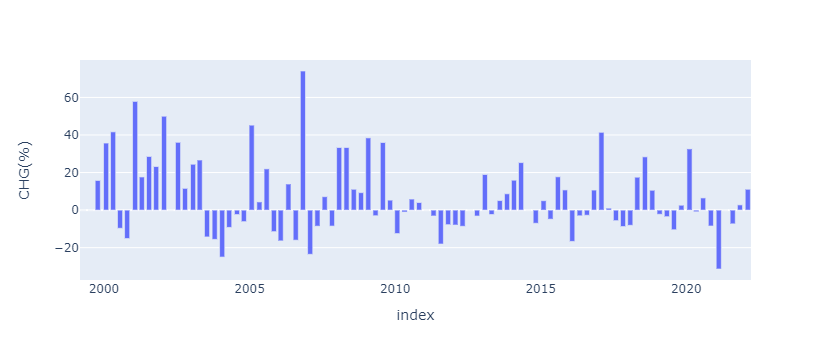

            Current Year EPS  Previous Year EPS  CHG(%)
2022-02-11              0.90               0.81   11.11
2021-11-05              1.11               1.08    2.78
2021-08-06              0.76               0.82   -7.32
2021-05-04              1.09               1.09    0.00
2021-02-12              0.81               1.18  -31.36
...                      ...                ...     ...
2000-04-25              0.51               0.36   41.67
2000-01-28              0.19               0.14   35.71
1999-10-15              0.66               0.57   15.79
1999-07-19              0.31               0.31    0.00
1999-04-16              0.36               0.36    0.00

[92 rows x 3 columns]


In [16]:
############### compare EPS with the previous year EPS ####################
earning_tmp1 = si.get_earnings_history(ticker)
earning_tmp2 = pd.DataFrame(earning_tmp1)
earnnona = earning_tmp2.dropna()
eps_act = np.array(earnnona['epsactual'])
eps_dat = earnnona['startdatetime']
eps_chg_pry = np.round((eps_act[:-4] - eps_act[4:])/eps_act[4:]*100, 2)
eps_smry = pd.DataFrame([eps_act[:-4],eps_act[4:], eps_chg_pry]).T
eps_smry.columns = ['Current Year EPS', 'Previous Year EPS', 'CHG(%)']
eps_smry.index = [dat[:10] for dat in eps_dat[:-4]]
eps_smry_sub = eps_smry.iloc[:, :]

# plot EPS change %
fig = px.bar(eps_smry_sub, x = eps_smry_sub.index, y = 'CHG(%)')
fig.show()

print(eps_smry_sub)

In [17]:
################ basic info #####################
variables = ['revenueGrowth', 'targetLowPrice', 'targetMedianPrice', \
'targetHighPrice', 'forwardPE', 'trailingPE', 'priceToBook', 'pegRatio', \
'quickRatio', 'shortRatio', 'payoutRatio', 'dividendYield', \
'enterpriseToRevenue', 'heldPercentInstitutions', 'beta', 'recommendationKey']

skinfo = stock.info
info = list(map(skinfo.get, variables))
basic_info = pd.DataFrame(info)
basic_info.index = variables
basic_info

,0
revenueGrowth,0.102
targetLowPrice,75
targetMedianPrice,86.5
targetHighPrice,95
forwardPE,19.171232
trailingPE,21.09799
priceToBook,2.664699
pegRatio,3.14
quickRatio,0.329
shortRatio,2.53


In [18]:
############## discount cash flow ############
unit = 'year'

if unit == 'quart':
    csh = stock.quarterly_cashflow
elif unit == 'year':
    csh = stock.cashflow
    
period = 15
fcsh = csh.loc['Total Cash From Operating Activities', :] + csh.loc['Capital Expenditures', :]
fcsh_chg = [(fcsh[i] - fcsh[i+1])/fcsh[i+1] for i in range(len(fcsh)-1)]
max_chg = np.max(fcsh_chg)
ave_chg = np.mean(fcsh_chg)
fcsh_ft = [fcsh[0]*(1+ave_chg)**n for n in range(period)]
csh_cur = np.sum([fcsh_ft[n-1]/(1+0.0177)**n for n in range(1, period+1)])/10**9
print(fcsh)
print(csh_cur)


2021-12-31   -2.024000e+09
2020-12-31   -1.104000e+09
2019-12-31   -1.170000e+08
2018-12-31    3.680000e+08
dtype: float64
-160942658.7718528


In [19]:
########### functions ############

## simple moving average
def fsma(price, days):
    smas = [np.mean(price[i:(i+days)]) for i in range(len(price)-days+1)]
    return smas

## exponential moving average
def fema(price, smooth, days):
    emas = [np.sum(price[:days])/days]
    for i in range(1, len(price[days:])):
        ema = price[i]*smooth/(1+days) + emas[i-1]*(1 - smooth/(1+days))
        emas.append(ema)
    return emas

## relative strength index
def frsi(gainloss, days):
    gain_ave1 = sum([gl for gl in gainloss[:days] if gl >= 0])/days
    loss_ave1 = sum([gl for gl in gainloss[:days] if gl < 0])/days
    gain_aves = [gain_ave1]
    loss_aves = [loss_ave1]

    gainloss_rsi = gainloss[14:]
    for i in range(1, len(gainloss_rsi)):

        if gainloss_rsi[i] >= 0:
            cg = gainloss_rsi[i]
            cl = 0
        elif gainloss_rsi[i] < 0:
            cg = 0
            cl = gainloss_rsi[i]

        gain_ave = (gain_aves[i-1]*(days-1) + cg)/days
        gain_aves.append(gain_ave)

        loss_ave = (loss_aves[i-1]*(days-1) + cl)/days
        loss_aves.append(loss_ave)

    rs_s = np.absolute(np.array(gain_aves)/np.array(loss_aves))
    rsis = 100 - 100/(1 + rs_s)
    return rsis

## money flow index
def fmfi(price, volumes, days):
    pos_marks = []
    neg_marks = []
    for i in range(1, len(price)):
        if price[i] >= price[i-1]:
            pos_mark = 1
            neg_mark = 0
        else:
            pos_mark = 0
            neg_mark = 1

        pos_marks.append(pos_mark)
        neg_marks.append(neg_mark)

    price_mfi = price[1:]
    volumes_mfi = volumes[1:]
    mfis = np.zeros(len(price_mfi)-days+1)
    for i in range(len(price_mfi)-days+1):
        pos_mf = np.sum(price_mfi[i:(i+days)]*volumes_mfi[i:(i+days)]*pos_marks[i:(i+days)])
        neg_mf = np.sum(price_mfi[i:(i+days)]*volumes_mfi[i:(i+days)]*neg_marks[i:(i+days)])
        mfr = pos_mf/neg_mf
        mfis[i] = 100 - 100/(1+mfr)
    return mfis


C:\Users\henry\AppData\Local\Temp/ipykernel_6016/172140023.py:64: RuntimeWarning:

divide by zero encountered in double_scalars



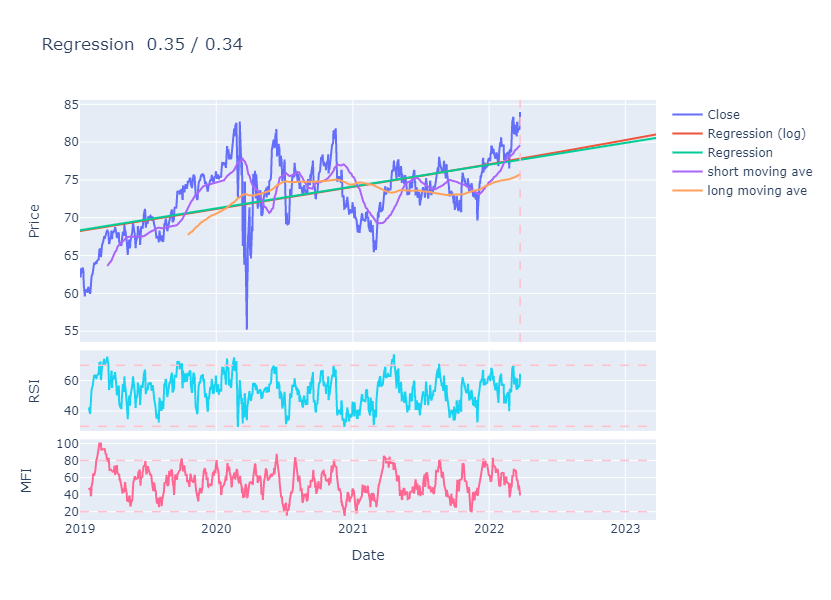

In [20]:
############### price range ####################
tdy = dt.datetime.today()
stdate = '2019-01-01'
eddate_tr = tdy
eddate_te = tdy

ma_type = 'sma'
preddays = 366  # future for prediction
mapd = (50, 200)  # (short, long) moving average period

# stock prices
stock = yf.Ticker(ticker)
skhist_tr = stock.history(start = stdate, end = eddate_tr).dropna()
skhist_te = stock.history(start = stdate, end = eddate_te).dropna()
skhigh_tr = skhist_tr['High']
sklow_tr = skhist_tr['Low']
skclose_tr = skhist_tr['Close']
skhigh_te = skhist_te['High']
sklow_te = skhist_te['Low']
skclose_te = skhist_te['Close']
sktyp_te = (skhigh_te + sklow_te + skclose_te)/3
skgl_te = [(skclose_te[i+1] - skclose_te[i])/skclose_te[i] for i in range(len(skclose_te)-1)]
skvol_te = skhist_te['Volume']

# dates
dates_tr = skhist_tr.index
dates_te = skhist_te.index

# moving average
if ma_type == 'sma':
    mashort = fsma(price = skclose_te, days = mapd[0])
    malong = fsma(price = skclose_te, days = mapd[1])

elif ma_type == 'ema':
    mashort = fema(price = skclose_te, smooth = 2, days = mapd[0])
    malong = fema(price = skclose_te, smooth = 2, days = mapd[1])

# create index for regression
time_tr = np.array((dates_tr - dates_tr[0])/np.timedelta64(1, 'D')).reshape(-1, 1)
time_te = np.array((dates_te - dates_te[0])/np.timedelta64(1, 'D')).reshape(-1, 1)
pred_tm = np.array(range(int(time_te[-1])+1, int(time_te[-1])+preddays)).reshape(-1, 1)
time_pred = np.concatenate((time_te, pred_tm))

# prediction and moving ave time for plot
tm_pred = [dt.date.fromisoformat(stdate) + dt.timedelta(days = int(time_pred[i])) for i in range(len(time_pred))]

# time for short and long moving average
tm_mas = dates_te[mapd[0]:]
tm_mal = dates_te[mapd[1]:]

## regression on log(price)
reg_close_log = LinearRegression().fit(time_tr, np.log(skclose_tr))
close_score1 = np.round(reg_close_log.score(time_tr, np.log(skclose_tr)), 2)
pred_close1 = np.exp(reg_close_log.predict(time_pred))

## regression on price
reg_close = LinearRegression().fit(time_tr, skclose_tr)
close_score2 = np.round(reg_close.score(time_tr, skclose_tr), 2)
pred_close2 = reg_close.predict(time_pred)

## relative strength index
rsi = frsi(gainloss = skgl_te, days = 14)

## money flow index
mfi = fmfi(price = sktyp_te, volumes = skvol_te, days = 14)

## plots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights = [0.6, 0.2, 0.2])

fig.add_trace(go.Scatter(x = dates_te, y = skclose_te, name = 'Close'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_pred, y = pred_close1, name = 'Regression (log)'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_pred, y = pred_close2, name = 'Regression'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_mas, y = mashort, name = 'short moving ave'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_mal, y = malong, name = 'long moving ave'),row=1, col=1)
fig.add_vline(x = dates_tr[-1], line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=1, col=1)

fig.add_trace(go.Scatter(x = dates_te[15:], y = rsi, showlegend = False), row = 2, col = 1)
fig.add_hline(y = 30, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=2, col=1)
fig.add_hline(y = 70, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=2, col=1)

fig.add_trace(go.Scatter(x = dates_te[15:], y = mfi, showlegend = False), row = 3, col = 1)
fig.add_hline(y = 20, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=3, col=1)
fig.add_hline(y = 80, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=3, col=1)

fig['layout']['xaxis3']['title'] = 'Date'
fig['layout']['yaxis']['title']='Price'
fig['layout']['yaxis2']['title']='RSI'
fig['layout']['yaxis3']['title']='MFI'
fig.update_layout(title='Regression  '+str(close_score1)+' / '+str(close_score2), width = 950, height = 600)
fig.show()

In [21]:
### RSI, MFI, Disparity analysis
# disparity
disp_short = (skclose_te[49:]/np.array(mashort)-1)*100
disp_long = (skclose_te[199:]/np.array(malong)-1)*100

####### analysis for RSI and MFI
def pctg_cut(ind, thd1, thd2):
    frac = np.mean((ind >= thd1)*(ind < thd2))
    pct = np.round(frac*100, 2)
    return pct

q_rsi = 0.05
q_mfi = 0.05
q_disp = 0.05
rsi_CrI = np.round(np.quantile(rsi, [q_rsi, 1-q_rsi]), 1)
mfi_CrI = np.round(np.quantile(mfi, [q_mfi, 1-q_mfi]), 1)
disp_CrI_s = np.round(np.quantile(disp_short, [q_disp, 1-q_disp]), 1)
disp_CrI_l = np.round(np.quantile(disp_long, [q_disp, 1-q_disp]), 1)

print('current RSI: ' + str(round(rsi[-1], 1)))
print(str(int((1-2*q_rsi)*100))+'%'+' CrI of RSI:', rsi_CrI)
print('current MFI: ' + str(round(mfi[-1], 1)))
print(str(int((1-2*q_mfi)*100))+'%'' CrI of MFI:', mfi_CrI)
print('current disparity (%): ' + str(round(disp_short[-1], 1)) + '(short), ' + str(round(disp_long[-1], 1)) + '(long)')
print(str(int((1-2*q_disp)*100))+'%'' CrI of Disparity (short):', disp_CrI_s, '%')
print(str(int((1-2*q_disp)*100))+'%'' CrI of Disparity (long):', disp_CrI_l, '%')

current RSI: 64.5
90% CrI of RSI: [37.2 69.1]
current MFI: 37.0
90% CrI of MFI: [28.7 79.7]
current disparity (%): 5.4(short), 10.8(long)
90% CrI of Disparity (short): [-6.4  6. ] %
90% CrI of Disparity (long): [-7.5  9.5] %


In [25]:
##################### historical PE ratio #####################
## eps
stock = yf.Ticker(ticker)
earning_tmp1 = si.get_earnings_history(ticker)
earning_tmp2 = pd.DataFrame(earning_tmp1)
earning = earning_tmp2[earning_tmp2['epsestimate'].notna()]

# actual earning
earn_act = earning.dropna()

# actual eps date
earntime = list(earn_act['startdatetime'].str[:10])

# price on actual earning date
price_cls = []
for i in range(len(earntime)):
    skprice = stock.history(start = earntime[i], end = dt.date.fromisoformat(earntime[i])+dt.timedelta(days = 1))
    price_cl = np.mean(skprice['Close'])
    price_cls.append(price_cl)

# actual eps
eps_act = list(earn_act['epsactual'])
eps_est = list(earning['epsestimate'])

# actual ttm eps
eps_ttms = [np.sum(eps_act[i:(i+4)]) for i in range(0, len(eps_act)-3)]

# pe ratios
pers = np.round(np.array(price_cls[0:-3])/np.array(eps_ttms), 2)

In [30]:
# summary (median per in the past five years, est. buy price)
skinfo = stock.info
trper = skinfo['trailingPE']

nqt = 13  # number of quarters
summary = pd.DataFrame([earntime, price_cls, pers]).T
summary.columns = ['Date', 'Close Price', 'PER']
med_per = np.median(summary['PER'][:nqt])
q13 = np.quantile(summary['PER'][:nqt], [0.25, 0.75])
estprice_act = eps_ttms[0]*med_per
estprice_est = (eps_est[0]+np.sum(eps_act[:3]))*med_per

crt_ratio = trper/summary['PER'][0]  # correction ratio

print('actual eps(TTM)', eps_ttms[0])
print('latest trper: ', trper)
print('latest per: ', pers[0])
print('median, Q1, Q3:', med_per, q13)
print('est. price (actual eps):', estprice_act)
print('est. price (est. eps):', estprice_est)
print(summary[:nqt])

actual eps(TTM) 8.95
latest trper:  33.972477
latest per:  32.17
median, Q1, Q3: 32.17 [27.94 35.39]
est. price (actual eps): 287.9215
est. price (est. eps): 293.0687
          Date Close Price    PER
0   2022-01-25  287.894714  32.17
1   2021-10-26  308.904938  36.34
2   2021-07-27  284.881195  35.39
3   2021-04-27  259.853394   35.4
4   2021-01-26  229.923325  34.27
5   2020-10-27  210.489883   34.0
6   2020-07-22  208.505249  36.26
7   2020-04-29  174.225937  30.78
8   2020-01-29  164.556046  30.47
9   2019-10-23  133.938858  26.84
10  2019-07-18  132.696716  27.94
11  2019-04-24  121.149673  26.86
12  2019-01-30  102.656563  23.76


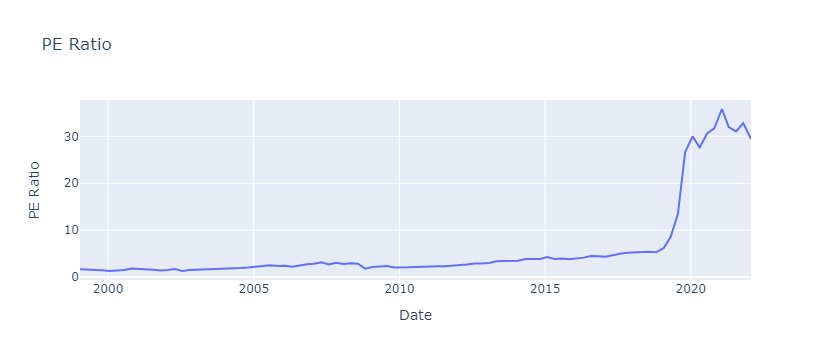

In [11]:
# plots
fig1 = go.Figure(data = go.Scatter(x = earntime[:-3], y = pers, name = 'PER'))
fig1.update_layout(title='PE Ratio', xaxis_title='Date', yaxis_title='PE Ratio')
fig1.show()

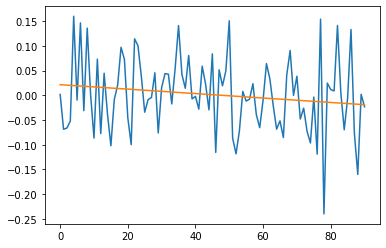

In [38]:
##### plot growth of per
perg = np.array([(pers[i]-pers[i+1])/pers[i+1] for i in range(len(pers)-1)]).reshape(-1, 1)
indeces = np.array(range(len(perg))).reshape(-1, 1)
fit_perg = LinearRegression().fit(indeces, perg)
perg_pred = fit_perg.predict(indeces)
plt.plot(perg)
plt.plot(perg_pred)
plt.show()

In [13]:
# compared with SP500 and NASDAQ100
ticker = 'nee'
periods = ['1mo', '3mo', '6mo', '1y', '2y', '5y']

def skprcchg(tk, prd):
    stock = yf.Tickers(tk+' voo qqq')
    skclose = stock.history(period = prd)['Close'].dropna()
    skchg_tmp = round((skclose.iloc[-1, :] - skclose.iloc[0, :])/skclose.iloc[0, :]*100, 2)
    skchg = pd.DataFrame(skchg_tmp).T
    return skchg

skchgs = None
for prd in periods:
    chg = skprcchg(ticker, prd)
    skchgs = pd.concat([skchgs, chg])
    
skchgs.index = periods
skchgs = skchgs[[ticker.upper(), 'VOO', 'QQQ']]
print('Stock Price CHG(%)')
skchgs

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
Stock Price CHG(%)


,NEE,VOO,QQQ
1mo,7.24,4.03,3.75
3mo,-7.57,-4.85,-10.83
6mo,7.64,2.97,-2.73
1y,15.60,15.89,14.26
2y,51.25,78.61,89.06
5y,187.59,112.25,184.53


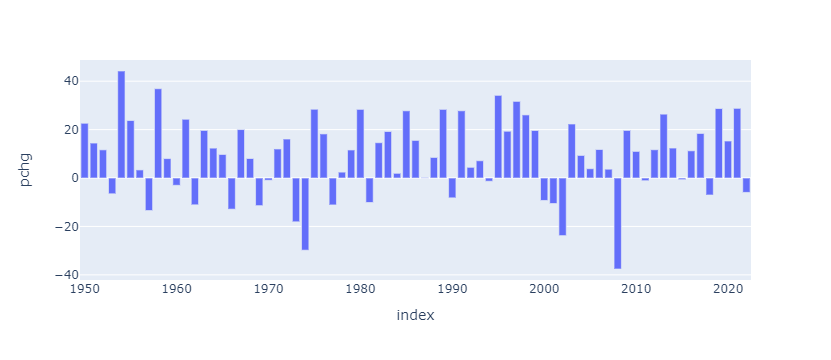

In [23]:
##### change % by year (sp500: ^GSPC, nasdaq: ^IXIC,  vix: ^VIX, Dow Jones: ^DJI)
stock = yf.Ticker('^GSPC')
sk = stock.history(period = 'max')
pchgs = []
for yr in np.unique(sk.index.year):
    sk1y = sk[sk.index.year == yr]['Close']
    pchg = (sk1y[-1]/sk1y[0] - 1)*100
    pchgs.append(pchg)
    
skchg = pd.DataFrame(data = pchgs, index = np.unique(sk.index.year), columns = ['pchg'])

# plot change %
fig = px.bar(skchg, x = skchg.index, y = 'pchg')
fig.show()